# **Predicting Stock Portfolio using NeuralForecast**

## ADSP 31018 Machine Learning II Class Project

Robin Lee

## 1. Problem Identification

In this project, I leverage historical stock market data to construct a sample portfolio, and predict its cumulative value through several months. Rather than forecast an individual stock or ETF—which is achievable using a univariate model—I seek to develop two deep learning models that will simultaneously forecast a set of 9. By incorporating a base investment amount and corresponding weights for each asset, my ultimate objective is to:
1. Produce individual forecasts for each stock
2. Compute an estimated final portfolio value

After constructing the models, I backtest through a set of rolling windows—each consisting of a pre-defined number of "look-ahead" days—before refitting after the cutoff dates. To measure accuracy and performance, I compute the Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE) of each individual asset, as well as the total portfolio.

### 1.1. Model Selection

To accomplish these objectives, I select a **Long Short-Term Memory** (LSTM) Recurrent Neural Network and a **Neural Hierarchical Interpolation for Time Series** (NHITS).

* I have decided not to pursue traditional time series models—such as SARIMA and Vector Autoregression—for the time being, because these models are not well-suited for extremely large and volatile datasets. ARIMA/VAR focus on short-term lags, which means they are not optimal for capturing long-term dependencies. As I will explain in further detail later, LSTMs and NHITS models use memory cells and hierarchical blocks respectively for long forecast horizons, which can model signals at multiple temporal resolutions. Furthermore, the traditional models assume linearity and model relationships as a linear combination, which is a major drawback considering financial data and stock returns are rarely linear. Finally, I seek to forecast multiple stocks at once, which ARIMA does not support.
  
* I also did not implement ensemble-based machine learning models—specifically XGBoost and Random Forest—because they do not naturally handle sequences or long-range temporal patterns. In boosting and bagging algorithms, each row is considered independent with no temporal ordering or autocorrelation, meaning seasonal and trend structures need to be manually added. As with ARIMA models, ensemble methods also only fit one model per series and cannot generalize across time series, which is not ideal for my objective. To forecast multiple stocks, I need to fit separate models for each asset, which is a significant disadvantage when stocks share macro patterns or seasonality. Therefore, deep learning models are a far better option to capture cross-series structures.

  
* Transformer models—such as the Temporal Fusion Transformer (TFT)—are extremely popular right now. However, these models contain a large number of hyperparameters and are difficult to tune, leading to high compute and memory cost. Considering the scope of this project, I will not use any transformers in order to preserve time and GPU. However, in future additions to this notebook, I seek to include these models to explore how they perform with different forecast windows and number of windows.

### 1.2. Assumptions and Hypotheses

Explicitly stating assumptions about the data and chosen models, and identifying the potential limitations:

1. Due to time constraints with this project and limited compute units on Google Colab, I assume that I will not reinvest or rebalance my portfolio. As such, I have not implemented any portfolio optimization techniques, such as the efficient frontier or VaR; I have ignored any expected risks/returns and correlation when completing this project. In other words, we can imagine that someone placed a cash lump sum into the selected stocks and completely forgot about the account for several years. Furthermore, I have chosen stocks that I already know will increase two-fold to three-fold, so there is some inherent bias and the final portfolio value will certainly be much larger than the initial investment.

2. We must remember that in trading, past performance is usually **not** a good predictor of future returns (Random Walk Theory). Machine learning models are trained and built upon past data, so I want to caution that we cannot expect extremely long-term forecasts to perform well. As such, I recommend limiting the forecast window to at most 1 month. Furthermore, in this project, I am strictly using each stock's close price. I will not be looking at quarterly earnings, news reports, and other external factors.

3. As mentioned earlier, I will focus on two models:

    * **Long Short-Term Memory (LSTM) Recurrent Neural Network**
  
      LSTMs are an extension of Recurrent Neural Networks (RNN) that learn patterens over a time sequence. RNNs use recurrent loops to remember information from previous steps in the sequence. According to the documentation on [Nixtla](https://nixtlaverse.nixtla.io/neuralforecast/models.lstm.html),  this model improves the exploding and vanishing gradient problem we often face when using simple RNNs by incorporating gate layers. The model will remember long-term dependencies using "cell states" and handle the sequence step-by-step, giving it the ability to retain and discard information. For example, the "forget gate" controls the flow of information and prevents any gradients from vanishing during back propagation. However, LSTMs are slow to train and extremely sensitive to hyperparameters. Furthermore, due to their complexity, these models tend to overfit.

    * **Neural Hierarchical Interpolation for Time Series (NHITS)**
  
      NHITS builds upon the Neural Basis Expansion Analysis (NBEATS) model, an  MLP-based deep neural network specifically for time series forecasting. According to the documentation on [Nixtla](https://nixtlaverse.nixtla.io/neuralforecast/models.nhits.html), this model is a feed-forward (no recurrence) deep learning model with hierarchical blocks. Unlike RNN/LSTM models, the NHITS model processes historical data all at once, rather than going step-by-step and looping through time. The NHITS model will break the forecasts into smaller chunks (blocks), before learning and refining the chunks using interpolation. Each block consists of input projection, MLP layers, and output projection. The model uses interpolation to focus on "important" parts of historical data, picking key points before forecasting. Instead of predicting all future values at once, NHITS creates smaller, layered models that make up parts of the forecast. Each block will combine to create the final output. As such, NHITS is better suited for the volatility we expect to see in long-horizon stock forecasting. Because it does not use sequential updates (no recurrence), NHITS are slightly faster to train. However, both methods are still computationally expensive.
  

   Comparing the two models, LSTMs are more ideal for simple or short-term predictions, while NHITS are better for long-horizon forecasts. While I am planning on forecasting several months of data, I believe both models will perform fairly similar, because I am splitting the test data into 2-week windows. However, I suspect that NHITS will edge out the LSTM, especially for longer forecast windows.

## 2. Exploratory Data Analysis and Feature Engineering

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from curl_cffi import requests
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from neuralforecast import NeuralForecast
from neuralforecast.auto import LSTM, NHITS, AutoNHITS, AutoLSTM
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
from neuralforecast.losses.pytorch import MAE, HuberLoss, MQLoss
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from utilsforecast.plotting import plot_series
session = requests.Session(impersonate="chrome")

### 2.1. Load Data

Using Yahoo Finance's `yfinance` package, I have imported the following stocks: J.P. Morgan (JPM), Wells Fargo (WFC), Bank of America (BAC), BAE Systems (BAESY), Leonardo DRS (DRS), RTX Corporation (RTX), Intel (INTC), Advanced Micro Devices (AMD), and Taiwan Semiconductor Manufacturing (TSM). In order to incorporate the effects of COVID-19 within the models, I set the start-date to January 1, 2019. The end date is the most recent date as of working on this project.

Investment weights and initial balance are randomly selected. I set a forecast horizon of 10 days and a look-ahead of 20 windows, with the horizon representing two weeks of stock prices (5 closing prices per week) and the look-ahead window representing about half a year.



In [81]:
# Initialize variables
tickers = ['JPM', 'WFC', 'BAC', 'BAESY', 'DRS', 'RTX', 'INTC', 'AMD', 'TSM']
# starting balance
initial_investment = 100000
# investment weights
weights = np.array([0.2, 0.05, 0.05, 0.1, 0.1, 0.2, 0.1, 0.1, 0.1])
# look-ahead days
forecast_horizon = 10
# number of look-ahead windows
n_windows = 20

**Potential quality issue:** `yfinance` pulls the latest data from Yahoo Finance, which updates and corrects prices day-to-day—this can be due to splits, dividends, or data corrections that retroactively alter historical prices. Furthermore, closing data for the most recent days are often revised after market close. Thus, I will download the most recent data as of 2025-05-25 locally and use that to tune/train. If I read the same data a week later, the prices may be slightly different even if my end date is still 2025-05-25. This makes analysis a bit difficult, since MAPE may shift 1-2% up or down. As a future consideration, I may optimize the model development process to account for shifting data. 

In [116]:
# Read in target stock data
stock_data = yf.download(tickers, start="2019-01-01", end="2025-05-25", interval='1d',
                         session=session,auto_adjust=False)['Close'].reset_index()
stock_data.to_csv('prices.csv', index=False)
stock_data = pd.read_csv('prices.csv')
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.set_index('Date', inplace=True)

[*********************100%***********************]  9 of 9 completed


In [83]:
stock_data.head()

Ticker,AMD,BAC,BAESY,DRS,INTC,JPM,RTX,TSM,WFC
Date,,,,,,,,,
2019-01-02,18.830000,24.959999,23.65,2.62,47.080002,99.309998,68.156075,36.520000,46.939999
2019-01-03,17.049999,24.559999,23.74,2.58,44.490002,97.110001,65.122719,34.360001,46.570000
2019-01-04,19.000000,25.580000,24.32,2.63,47.220001,100.690002,67.350533,34.970001,47.950001
2019-01-07,20.570000,25.559999,24.15,2.63,47.439999,100.760002,67.319069,35.230000,47.639999
2019-01-08,20.750000,25.510000,24.57,2.61,47.740002,100.570000,68.533669,34.939999,47.540001


I have also read in S&P 500 closing prices as a broad measure of the overall U.S. stock market. I will not be predicting the S&P 500, but rather, utilizing it as an exogenous variable. Many individual stocks and portfolios are influenced by overall market trends and volatility.

In [117]:
# Read in sp500 dataset (exogenous variable)
sp500_data = yf.download(['^GSPC'], start="2019-01-01", end="2025-05-25", interval='1d',
                         session=session,auto_adjust=False)['Close'].reset_index()
sp500_data.to_csv('sp500.csv', index=False)
sp500_data = pd.read_csv('sp500.csv')
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
sp500_data.set_index('Date', inplace=True)

[*********************100%***********************]  1 of 1 completed


### 2.2. Exploratory Data Analysis

**Daily Close Prices of Each Stock and S&P 500**

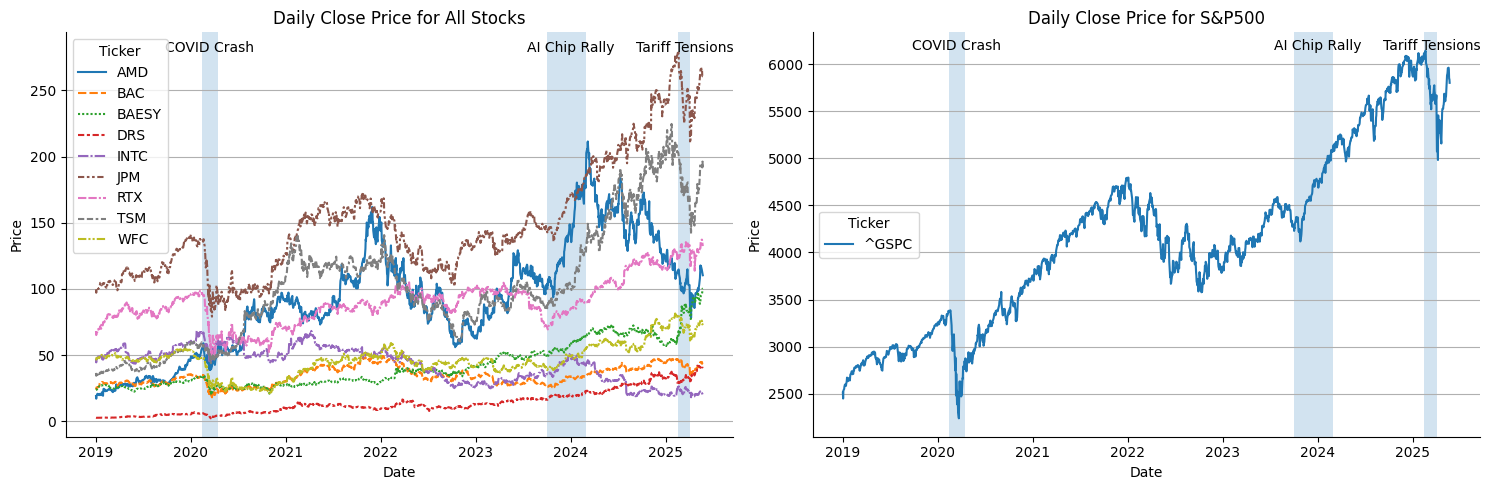

In [85]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.lineplot(stock_data)
plt.ylabel('Price')
plt.title('Daily Close Price for All Stocks')
sns.despine(top=True, bottom=False)
# major events
plt.axvspan(pd.Timestamp('2020-02-15'), pd.Timestamp('2020-04-15'), alpha=0.2)
plt.text(pd.Timestamp('2020-03-15'), plt.ylim()[1]*0.95, 'COVID Crash',ha='center')
plt.axvspan(pd.Timestamp('2023-10-01'), pd.Timestamp('2024-03-01'), alpha=0.2)
plt.text(pd.Timestamp('2024-01-01'), plt.ylim()[1]*0.95, 'AI Chip Rally',ha='center')
plt.axvspan(pd.Timestamp('2025-02-15'), pd.Timestamp('2025-04-04'), alpha=0.2)
plt.text(pd.Timestamp('2025-03-15'), plt.ylim()[1]*0.95, 'Tariff Tensions',ha='center')
plt.grid(axis='y')
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.lineplot(sp500_data)
plt.ylabel('Price')
plt.title('Daily Close Price for S&P500')
sns.despine(top=True, bottom=False)
# major events
plt.axvspan(pd.Timestamp('2020-02-15'), pd.Timestamp('2020-04-15'), alpha=0.2)
plt.text(pd.Timestamp('2020-03-15'), plt.ylim()[1]*0.97, 'COVID Crash',ha='center')
plt.axvspan(pd.Timestamp('2023-10-01'), pd.Timestamp('2024-03-01'), alpha=0.2)
plt.text(pd.Timestamp('2024-01-01'), plt.ylim()[1]*0.97, 'AI Chip Rally',ha='center')
plt.axvspan(pd.Timestamp('2025-02-15'), pd.Timestamp('2025-04-05'), alpha=0.2)
plt.text(pd.Timestamp('2025-03-15'), plt.ylim()[1]*0.97, 'Tariff Tensions',ha='center')
plt.grid(axis='y')
plt.tight_layout()

Analyzing the daily close prices for the 9 stocks and the S&P 500, we can see several instances of sharp increases and decreases.
* Most notably, we see a sudden downturn in all prices at the beginning of 2020, coinciding with COVID-19 and the ensuing pandemic. However, unlike previous crashes, the market recovered exceptionally quick—recovering all losses in the span of 4 months.
* In 2022, we see markets beginning to tumble again, likely caused by high inflation, rising interest rates, and the Federal Reserve's aggressive monetary policy tightening to combat inflation (The Federal Reserve raised interest rates 11 times starting in March 2022). Furthermore, Russian officially invaded Ukraine in February 2022, kickstarting the ongoing war and increasing defense stocks.
* Towards the latter half of 2024, we see chip stocks explode in value, most likely caused by a flurry of artificial intelligence development and the ensuing excitement. While not featured, Nvidia's market value increased by over 2 trillion in the span of a year and reached 3.28 trillion at the close 2024, highlightiing the market's positive attitude towards the semiconductor industry.
* Most recently, the Trump administration has imposed a series of aggressive tariffs, culminating in the April 2nd "Liberation Day"—when the president unveiled reciprocal tariffs targeting approximately 60 countries. Much like after the COVID-19 crash, we see the markets recover quickly, with prices returning to pre-administration prices within a month.

**Forecast Horizon Rolling Volatility**

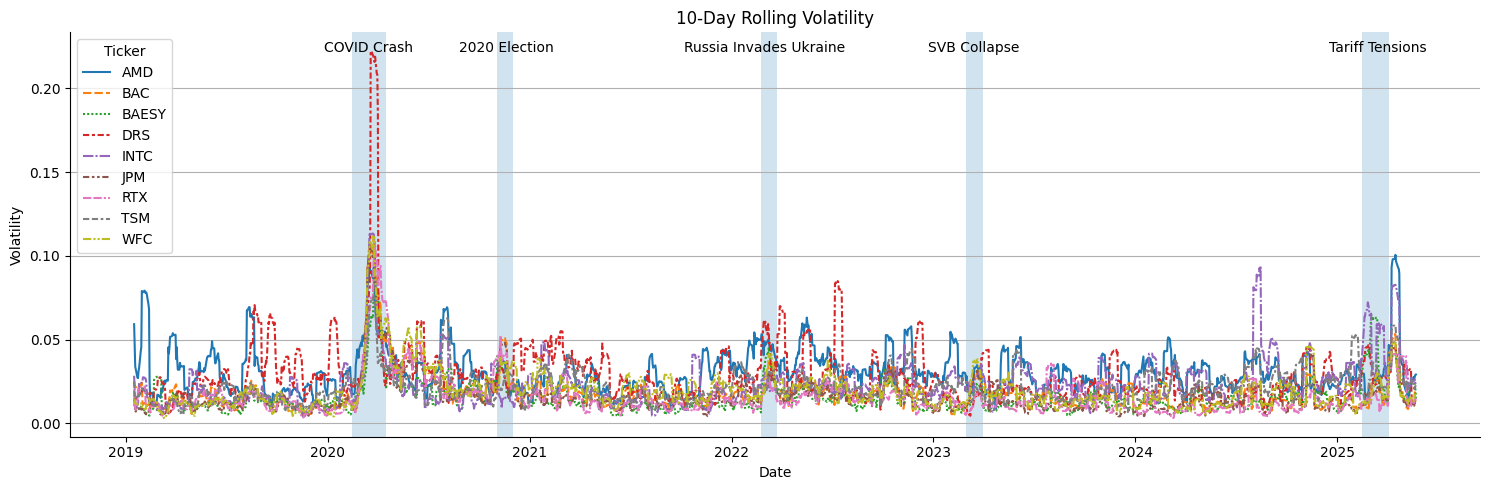

In [86]:
# volatility is how much a stock fluctuates over time (sd of returns)
returns = stock_data.pct_change()
# rolling window depending on horizon
rolling_vol = returns.rolling(window=forecast_horizon).std()

plt.figure(figsize=(15, 5))
sns.lineplot(rolling_vol)
plt.title(f"{forecast_horizon}-Day Rolling Volatility")
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.tight_layout()
sns.despine(top=True, bottom=False)

# major events
plt.axvspan(pd.Timestamp('2020-02-15'), pd.Timestamp('2020-04-15'), alpha=0.2)
plt.text(pd.Timestamp('2020-03-15'), plt.ylim()[1]*0.95, 'COVID Crash',ha='center')
plt.axvspan(pd.Timestamp('2020-11-03'), pd.Timestamp('2020-12-01'), alpha=0.2)
plt.text(pd.Timestamp('2020-11-20'), plt.ylim()[1]*0.95, '2020 Election',ha='center')
plt.axvspan(pd.Timestamp('2022-02-24'), pd.Timestamp('2022-03-24'), alpha=0.2)
plt.text(pd.Timestamp('2022-03-01'), plt.ylim()[1]*0.95, 'Russia Invades Ukraine',ha='center')
plt.axvspan(pd.Timestamp('2023-03-01'), pd.Timestamp('2023-04-01'), alpha=0.2)
plt.text(pd.Timestamp('2023-03-15'), plt.ylim()[1]*0.95, 'SVB Collapse',ha='center')
plt.axvspan(pd.Timestamp('2025-02-15'), pd.Timestamp('2025-04-05'), alpha=0.2)
plt.text(pd.Timestamp('2025-03-15'), plt.ylim()[1]*0.95, 'Tariff Tensions',ha='center')

plt.grid(axis='y')
plt.show()

Continuing with our previous analysis, there are several instances of increased volatility.
* As expected, the COVID-19 crash beginning of 2020 caused the biggest spike in volatility as almost all the stocks tanked.
* We see a slight increase during the 2020 election, most likely caused by market uncertainty regarding each political party's view on the COVID-19 pandemic, international relations, and other socioeconomic factors.
* The Russian invasion of Ukraine did not cause any significant volatility, though we do see minor spikes for DRS (pink) and the other defense companies.
* Likewise, the collapse of Silicon Valley Bank beginning of 2023 did not affect market volatility, most likely because the 3 banks I have chosen (JPM, WFC, BAC) are "systemically important financial institutions" and carry the most assets/capitalization. The collapse did not pose any significant risk to these major banks.
* Lastly, we see an increase in volatility with the ongoing tariff tensions, especially for the chip manufacturers who see China as a large and important market.

### 2.3. Transform Data into NeuralForecast Format

The input to NeuralForecast is always a data frame in long format with three columns: `unique_id`, `ds` and `y`:

* The `unique_id` (string, int or category) represents an identifier for the series.
* The `ds` (datestamp or int) column should be either an integer indexing time or a datestampe, ideally like `YYYY-MM-DD` for a date or `YYYY-MM-DD HH:MM:SS` for a timestamp.
* The `y` (numeric) represents the measurement we wish to forecast.

In this case, I have also included the corresponding S&P 500 values at its respective date.

In [87]:
df_long = stock_data.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
df_long.rename(columns={'Date': 'ds'}, inplace=True)
df_long = df_long.dropna()

sp500_long = sp500_data.reset_index().melt(id_vars='Date', var_name='sp500_id', value_name='sp500')
sp500_long.drop(columns=['sp500_id'], inplace=True)
sp500_long.rename(columns={'Date': 'ds'}, inplace=True)
sp500_long = sp500_long.dropna()

# merge so that each ticker's date has corresponding sp500
df_long = df_long.merge(sp500_long, on='ds', how='left')

In [88]:
df_long.head()

,ds,unique_id,y,sp500
0,2019-01-02,AMD,18.830000,2510.030029
1,2019-01-03,AMD,17.049999,2447.889893
2,2019-01-04,AMD,19.000000,2531.939941
3,2019-01-07,AMD,20.570000,2549.689941
4,2019-01-08,AMD,20.750000,2574.409912


### 2.4. Feature Engineering

**Historical Exogenous Variables**

From the [NIXTLA documentation](https://nixtlaverse.nixtla.io/neuralforecast/docs/capabilities/exogenous_variables.html):
> This time-dependent exogenous variable is restricted to past observed values. Its predictive power depends on Granger-causality, as its past values can provide significant information about future values of the target variable
y.

In [89]:
# is COVID
df_long['is_covid'] = df_long['ds'].between(pd.Timestamp('2020-02-15'), pd.Timestamp('2020-05-15'))

The `is_covid` variable flags all dates that are within the COVID-19 market crash window. This can help the model identify market regime changes similar to those during the pandemic. More specifically, I want the model to learn the relationship between variables during similar outlier events, improving generalization for future periods of economic downturn and subsequent recovery.

In [90]:
# Day of Week
df_long['day_of_week'] = df_long['ds'].dt.dayofweek
df_long['dow_sin'] = np.sin(2 * np.pi * df_long['day_of_week'] / 7)
df_long['dow_cos'] = np.cos(2 * np.pi * df_long['day_of_week'] / 7)

Since market behavior can depend on the day (beginning vs. end of the week), I encode the day of the week using cyclical encoding (sin and cos), which preserves weekday continuity. If I had used `day_of_week` itself, the model will treat Sunday (6) and Monday (0) as far apart, rather than side-by-side. Neural networks can more easily learn the impact of weekly seasonality when given these cyclical features.

In [91]:
# Rolling Window Volatility
df_long['return_1d'] = df_long.groupby('unique_id')['y'].pct_change()
df_long[f'volatility_{forecast_horizon}d'] = (
    df_long.groupby('unique_id')['return_1d']
      .rolling(window=forecast_horizon)
      .std()
      .reset_index(level=0, drop=True)
)

In order to avoid "Look-Ahead Bias", I calculate each stock's volatility using only the lagged returns (`return_1d`), which prevents accidental leakage of future information. Furthermore, I have made sure to align the window with the pre-defined forecast horizon. This variable allows the models to identify whether high-risk periods (volatility) correlate with specific price patterns, and adjust predictions based on market conditions.

In [92]:
# Rolling means and standard deviations
df_long['rolling_mean_7'] = df_long.groupby('unique_id')['y'].transform(lambda x: x.rolling(7).mean())
df_long['rolling_std_7'] = df_long.groupby('unique_id')['y'].transform(lambda x: x.rolling(7).std())
df_long['rolling_std_14'] = df_long.groupby('unique_id')['y'].transform(lambda x: x.rolling(14).std())

The 7-day rolling average (`rolling_mean_7`) helps our models understand whether each series is currently trending up or down, which can improve short-term forecasts. This process smoothens any short-term fluctuations, uncovering the overall trend in the past week. The 7-day (`rolling_std_7`) and 14-day (`rolling_std_14`) rolling standard deviations measure the recent volatility in the past week and past 2 weeks, allowing the model to detect periods of high or low uncertainty.

In [93]:
# Lagged Returns
for lag in [1, 2, 5, 10]:
    df_long[f'return_lag_{lag}'] = df_long.groupby('unique_id')['return_1d'].shift(lag)

I have implemented 1-day, 2-day and 5-day lagged returns for the models to detect short-term and medium-term dependencies for each stock, capturing autocorrelation and other temporal patterns within the data.

In [94]:
# Lagged and Rolling SP500 values
df_long['sp500_return_1d'] = df_long['sp500'].pct_change()
df_long['sp500_rolling_vol_14d'] = df_long['sp500_return_1d'].rolling(14).std()

By including the S&P 500’s daily returns (`sp500_return_1d`), the models can learn how each stock moves in relation to the market. This is known as a stock's “beta exposure”, or sensitivity to market movements.

The 14-day rolling volatility of the S&P 500 (`sp500_rolling_vol_14d`) allows our models to quantify the overall market risk or uncertainty. Periods of high overall market volatility typically coincide with large moves in individual stocks. By including this feature, I seek to adjust each model's forecasts depending on market regime.

In [95]:
# Scaling
scaler = StandardScaler()
#+ [f'return_lag_{lag}' for lag in [1,2,5]]
for col in ['sp500_return_1d','sp500_rolling_vol_14d']:
    df_long[col] = df_long.groupby('unique_id')[col].transform(
        lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

df_long = df_long.dropna().reset_index(drop=True)

Finally, I have scaled the two exogenous S&P 500 variables. Scaling ensures that features like rolling means and volatility have the same scale across all stocks, making them comparable and preventing the size of the S&P 500 price from dominating the model. The S&P 500 is an aggregation across stocks, so there is a significant magnitude difference when compared to the individual stocks themselves.

**Note:** Because `NeuralForecast` treats each `unique_id` as a separate time series, we can conduct per-stock modeling and process each series independently. As such, I have decided not to scale any exogenous variables derived from the stocks themselves. I calculated all the other features (rolling means, lagged returns, volatility) within each stock, so I do not have to worry about any one stock from dominating the development process. I also want to forecast in the original units, so the final output will be in dollar value.

In [96]:
df_long.head()

,ds,unique_id,y,sp500,is_covid,day_of_week,dow_sin,dow_cos,return_1d,volatility_10d,rolling_mean_7,rolling_std_7,rolling_std_14,return_lag_1,return_lag_2,return_lag_5,return_lag_10,sp500_return_1d,sp500_rolling_vol_14d
0,2019-01-23,AMD,19.799999,2638.699951,False,2,0.974928,-0.222521,0.002024,0.026990,20.131428,0.387790,0.945713,-0.048628,0.025679,0.007415,0.008751,0.123157,0.379969
1,2019-01-24,AMD,20.850000,2642.330078,False,3,0.433884,-0.900969,0.053030,0.031082,20.220000,0.475044,0.514043,0.002024,-0.048628,-0.031894,-0.026988,0.059362,0.029064
2,2019-01-25,AMD,21.930000,2664.760010,False,4,-0.433884,-0.900969,0.051799,0.032982,20.441429,0.807185,0.594092,0.053030,0.002024,0.026356,-0.022288,0.607935,-0.458109
3,2019-01-28,AMD,20.180000,2643.850098,False,0,0.000000,1.000000,-0.079799,0.043025,20.505714,0.757471,0.593280,0.051799,0.053030,0.025679,0.026849,-0.651907,-0.385738
4,2019-01-29,AMD,19.250000,2640.000000,False,1,0.781831,0.623490,-0.046085,0.045487,20.362857,0.895465,0.647483,-0.079799,0.051799,-0.048628,-0.001973,-0.159047,-0.413957


**Static Exogenous Variables**

From the [NIXTLA documentation](https://nixtlaverse.nixtla.io/neuralforecast/docs/capabilities/exogenous_variables.html):
> The static exogenous variables carry time-invariant information for each time series. When the model is built with global parameters to forecast multiple time series, these variables allow sharing information within groups of time series with similar static variable levels. Examples of static variables include designators such as identifiers of regions, groups of products, etc.

In [97]:
# One-Hot Encode Each Company's Industry
defense_tickers = {'BAESY', 'RTX', 'DRS'}
bank_tickers = {'JPM', 'BAC', 'WFC'}
chip_tickers = {'AMD', 'INTC', 'TSM'}
static_df = pd.DataFrame({'unique_id': df_long['unique_id'].unique()})

static_df['is_def'] = static_df['unique_id'].isin(defense_tickers).astype(int)
static_df['is_bank'] = static_df['unique_id'].isin(bank_tickers).astype(int)
static_df['is_chip'] = static_df['unique_id'].isin(chip_tickers).astype(int)

The models can use these columns to learn industry-specific patterns. The most recent example is the market reaction to the trade war and the 2025 Trump Administration's stance on international relations. While banks and chipmakers generally witnessed a significant downturn, we see international defense stocks spike.

> According to [CNBC](https://www.cnbc.com/2025/04/08/lack-of-trust-in-the-us-boosts-european-and-asian-defense-stocks.html), European nations are increasing their military spending due to political and economic uncertainty, including a perceived lack of reliability from the U.S. (the Trump Administration has threatened to leave NATO on several occasions). Unlike the previous administration, the Trump Administration has been extremely hesitant to support Ukraine in their war with Russia.

Because European nations have expressed commitment to boosting their own military spending in response to the United States' isolationist policies, international defense companies (BAESY, DRS) spiked recently (2025 Q1).

In [98]:
static_df

,unique_id,is_def,is_bank,is_chip
0,AMD,0,0,1
1,BAC,0,1,0
2,BAESY,1,0,0
3,DRS,1,0,0
4,INTC,0,0,1
5,JPM,0,1,0
6,RTX,1,0,0
7,TSM,0,0,1
8,WFC,0,1,0


### 2.5. Train, Test, and Validation Data Split

In [99]:
# Split data
n_points = n_windows * forecast_horizon

all_dates = df_long['ds'].sort_values().unique()
test_dates = all_dates[-n_points:]
val_dates = all_dates[-(2 * n_points):-n_points]
train_dates = all_dates[:-(2 * n_points)]

train_df = df_long[df_long['ds'].isin(train_dates)]
val_df   = df_long[df_long['ds'].isin(val_dates)]
test_df  = df_long[df_long['ds'].isin(test_dates)]

I split the dataset into training, validation and testing segments. Rather than segment the data by percentages—such as 70%, 15%, and 15%—I determine the size of my validation and test splits by multiplying the forecast horizon (`forecast_horizon`) by the number of windows (`n_windows`). I have decided to do this, because the cross-validation function in `NeuralForecast` uses this product to determine what size to backtest the model. I do not want to set a percentage split, only for the backtesting to begin signficantly after the end of the validation dataset (which is where I train my model up to). This also makes the program more dynamic.

I will build the models using the train and validation datasets, before testings its accuracy on the unseen test data.

**Plot of Data Splits for Select Chip-Related Stocks**

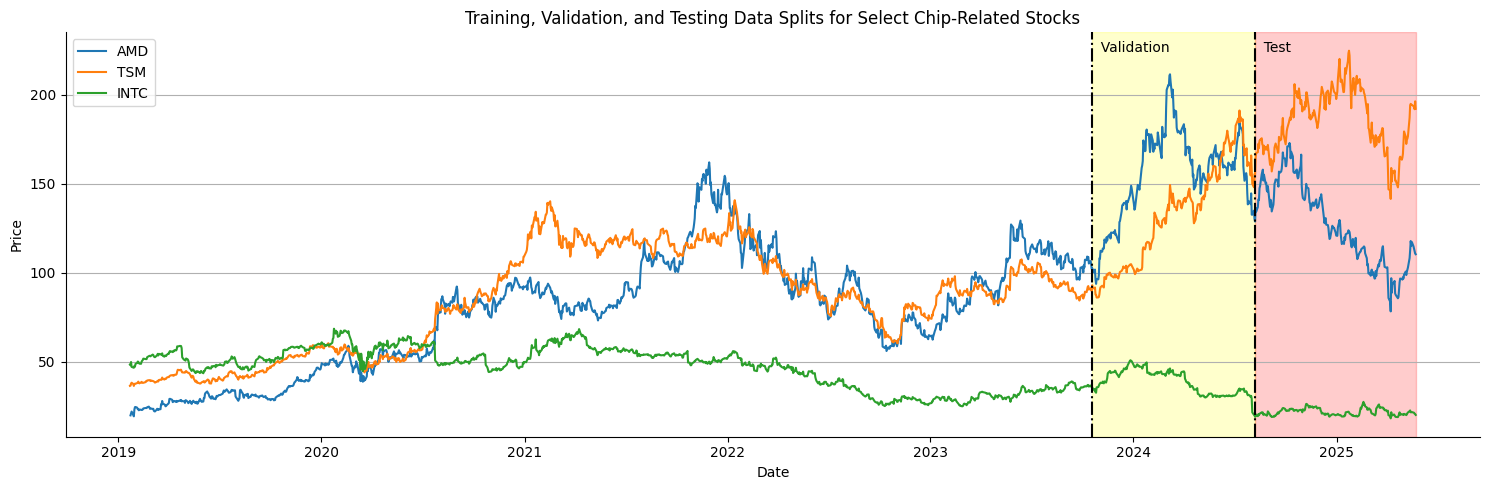

In [100]:
fig = plt.figure(figsize=(15, 5))

x_plot = pd.to_datetime(df_long[df_long.unique_id == "AMD"].ds)
for stock in ["AMD", "TSM", "INTC"]:
    stock_data = df_long[df_long.unique_id == stock]
    plt.plot(pd.to_datetime(stock_data.ds), stock_data.y.values, label=stock)

val_start_date = pd.to_datetime(val_dates[0])
val_end_date = pd.to_datetime(val_dates[-1])
test_start_date = pd.to_datetime(test_dates[0])
test_end_date = pd.to_datetime(test_dates[-1])

plt.axvline(val_start_date, color='black', linestyle='-.')
plt.axvspan(val_start_date, val_end_date, color='yellow', alpha=0.2)
plt.axvline(test_start_date, color='black', linestyle='-.')
plt.axvspan(test_start_date, test_end_date, color='red', alpha=0.2)

plt.text(val_start_date, df_long.y.max()*0.8, '  Validation', fontsize=10)
plt.text(test_start_date, df_long.y.max()*0.8, '  Test', fontsize=10)

plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Training, Validation, and Testing Data Splits for Select Chip-Related Stocks')
sns.despine(top=True, bottom=False)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## 3. Model Development

### 3.1. Modeling Approach

Because of computational limitations and time constraints, I have split the model development process into two steps:

1. In order to hyperparameter tune the models, I have leveraged `NeuralForecast`'s AutoNHITS and AutoLSTM models, which build on top of [ray](https://docs.ray.io/en/latest/index.html)—a flexible distributed computing framework for accelerating ML workloads. With a wide variety of hyperparameter optimization tools to choose from in raytune, I have decided to use [HyperOptSearch](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.search.hyperopt.HyperOptSearch.html), which implements Bayesian optimization algorithms (Tree-structured Parzen Estimator) to effectively handle complex, high-dimensional, and conditional hyperparameter spaces. As such, the Auto models are much more user-friendly when tuning compared to the regular models, reducing computational expense.

    In both cases, I select the default configuration in order to simplify the process, though I have also included several extra parameters to tune (such as gradient clipping and dropout) to mitigate overfitting/underfitting. The default search space dictionary can be accessed through the `get_default_config` function of the Auto model. Finally, I use Mean Absolute Error (MAE) because it is easy to interpret and robust to outliers. This is crucial, because I am forecasting a dollar amount and the stock market tends to fluctuate frequently, creating outliers.

   **Note:** When I ran the hyperparameter tuning, I had not yet created the exogenous variables, so we can interpret the tuned-models as our "baseline" to build upon. With further time and computational resources, I seek to run the tuning again with these new parameters.
   
2. After tuning, I will retrieve both models' hyperparameters, properly formatting them before printing out each tuned value. Because I do not want to rerun the hyperparameter tuning every time I work on this project, I manually extract and input each value into a separate "final" model. This is acceptable, because I have already saved the dataset as of 2025-05-25. As mentioned in the [Exploratory Data Analysis](#2.1.-Load-Data), data after 2025-05-25 may appear different due to revisions and updates, which can positively or negatively affect model performance. To make analysis easier, I am sticking with a point-in-time dataset. In section [3.3 Construct Final Models](#3.3.-Construct-Final-Models), I will discuss the parameters for the final models.

### 3.2. Hyperparameter Tuning

**Define the hyperparameter grid:**

In [ ]:
# Using default hyperparameter grid:
nhits_config = AutoNHITS.get_default_config(h = forecast_horizon, backend="ray") # Extract the default hyperparameter settings
nhits_config["random_seed"] = tune.randint(1, 10)
nhits_config["n_pool_kernel_size"] = tune.choice([[2, 2, 2], [16, 8, 1]])
nhits_config["n_freq_downsample"] = tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]])
nhits_config["gradient_clip_val"] = tune.uniform(0.1, 10.0)
nhits_config["interpolation_mode"] = tune.choice(["linear", "nearest"])
nhits_config["dropout_prob_theta"] = tune.uniform(0.0, 1)

The default grid is useful for when I want to change hyperparameter spaces without changing the other default values:
* `n_pool_kernel_size`: The size of the pooling kernel used when downsampling the time series at each block.
* `n_freq_downsample`: The number of frequency components retained after downsampling, reducing dimensionality.
* `gradient_clip_val`: The maximum allowed value for gradients during backpropagation, reducing the risk of exploding gradients.
* `interpolation_mode`: The method used to interpolate basis functions when projecting outputs into the forecast space.
* `dropout_prob_theta`: Dropout probability applied to the theta parameters in each block, preventing overfitting.

Since models have different hyperparameters, configuration dictionaries are not interchangeable.

* `encoder_dropout`: Randomly zeros out part of the encoder's hidden layer during training, helping the LSTM avoid overfitting.

In [ ]:
# Using default hyperparameter grid:
lstm_config = AutoLSTM.get_default_config(h = forecast_horizon, backend="ray") # Extract the default hyperparameter settings
lstm_config["random_seed"] = tune.randint(1, 10)
lstm_config["gradient_clip_val"] = tune.uniform(0.1, 10.0)
lstm_config["encoder_dropout"] = tune.uniform(0.0, 1)

By implementing the dropout and gradient clipping parameters, I seek to mitigate overfitting/underfitting in my models, which may pose a serious issue when predicting stock data.

**Instantiate the auto models:**

**Note:** `num_samples` represents the number of configurations in the search space, so a larger value will usually produce better results. However, because of limited compute units and time, I have selected an extremely small number of samples. The Nixtla documentation recommends `num_samples` higher than 20 as a general rule.

In [ ]:
# Set up Auto NHITS model:
auto_nhits = AutoNHITS(h=forecast_horizon,loss=MAE(),config=nhits_config,
                       search_alg=HyperOptSearch(),backend='ray',num_samples=10)
# Set up Auto LSTMM model:
auto_lstm = AutoLSTM(h=forecast_horizon, config=lstm_config,search_alg=HyperOptSearch(),
                     backend='ray',num_samples=10)

**Initialize and train the auto models:**

In [ ]:
# Initialize models:
nf = NeuralForecast(models=[auto_nhits, auto_lstm], freq='B') # freq='B' for business days

Auto models will automatically train multiple models with different hyperparameters, produce forecasts on the validation set, and evaluate them based on our selected loss function (MAE).

In [ ]:
# Combine training and validation data (nf format uses val_size)
full_trainval_df = pd.concat([train_df, val_df])
val_size = len(val_df['ds'].unique())
# Note that test data is not included at all (unseen data)

# Fit models to training data
nf.fit(df=full_trainval_df, val_size=val_size)

> *Output hidden due to size.*

### 3.3. Final Models

After tuning both Auto models, I sort the results by their training and validation loss (MAE), before printing the optimal hyperparameters for the model with the least amount of loss.

In [ ]:
# Sort model results by validation loss:
nhits_results = nf.models[0].results.get_dataframe().sort_values("loss") # sort is naturally ascending
lstm_results = nf.models[1].results.get_dataframe().sort_values("loss")
#print(lstm_results.head())

**Output best hyperparameters:**

In [ ]:
# Retrieve best NHITS hyperparameters:
best_nhits_params = nhits_results.iloc[0].filter(like='config/').to_dict()
# Format correctly
best_nhits_config = {k.replace("config/", ""): v for k, v in best_nhits_params.items() if "valid_loss" not in k}
best_nhits_config

{'h': 14,
 'n_pool_kernel_size': (16, 8, 1),
 'n_freq_downsample': (24, 12, 1),
 'learning_rate': 0.02265480654756856,
 'scaler_type': 'standard',
 'max_steps': 600.0,
 'batch_size': 128,
 'windows_batch_size': 256,
 'loss': MAE(),
 'random_seed': 3,
 'input_size': 42,
 'step_size': 1,
 'gradient_clip_val': 9.157110462607644,
 'interpolation_mode': 'nearest',
 'dropout_prob_theta': 0.03289978065109933}

In [ ]:
# Retrieve best LSTM hyperparameters:
best_lstm_params = lstm_results.iloc[0].filter(like='config/').to_dict()
# Format correctly
best_lstm_config = {k.replace("config/", ""): v for k, v in best_lstm_params.items() if "valid_loss" not in k}
best_lstm_config

{'h': 14,
 'encoder_hidden_size': 32,
 'encoder_n_layers': 2,
 'context_size': 5,
 'decoder_hidden_size': 128,
 'learning_rate': 0.005271068881170671,
 'max_steps': 1000,
 'batch_size': 16,
 'loss': MAE(),
 'random_seed': 7,
 'input_size': -14,
 'inference_input_size': -14,
 'gradient_clip_val': 3.1416410503070638,
 'encoder_dropout': 0.8923267784405099}

**Final model justification:**

As mentioned in section [3.1 Modeling Approach](#3.1.-Modeling-Approach), I have included several new hyperparameters to both tuned models:
  * `hist_exog_list`: See [2.3. Exogenous Variables](#2.3.-Exogenous-Variables) for definitions.
  * `stat_exog_list`: See [2.3. Exogenous Variables](#2.3.-Exogenous-Variables) for definitions.

For both models, I use `scaler_type='standard'` to ensure inputs have zero mean and unit variance, which is useful when values vary in magnitude. Because I select a fairly high `max_steps` of 1000, I also incorporate validation checks every 50 steps to prevent overfitting, and I stop training if the validation loss remains constant for 200 steps. I use a relatively large `input_size`, `batch_size`, and `windows_batch_size` to improve model generalization. I select a learning_rate that is lower than the tuned value to ensure stable convergence, sacrificing some compute speed as a result. Finally, I implement `gradient_clip_val` to mitigate exploding gradients, helping stabilize the deep training process.

* For **NHITS**, I have selected and tuned these additional model-specific parameters:
    * `n_pool_kernel_size` controls the temporal resolution or hierarchical downsampling process of each block in the NHITS hierarchy. By using (2,2,2), I employ gradual pooling such that the model learns from local and global patterns without overly aggressive downsampling. NHITS will only aggregate every 2 time steps within each block, which can help model multi-scale patterns. In other words, block 1 will see 1/2 the data points, block 2 will see 1/4, and block 3 will see 1/8. This helps prevent overfitting by reducing the amount of "detail" in the input.
    * This corresponds well with an `n_freq_downsample` of (24, 12, 1), which controls the number of basis functions or frequency components within each hierarchical block. The first block uses 24 functions (broad seasonal patterns), the second uses 12 (refined details), and the final block uses just 1 function (final trend). NHITS predicts future values by estimating the basis coefficients—called theta—for each block, then reconstructing the output using basis functions. The basis functions can be Fourier, polynomial, sinusoid, etc. to fit data signals or trends—these are added together to form each window's prediction.
    * I utilize `dropout_prob_theta` to randomly zero out the theta layers or basis coefficients, improving regularization. Finally, the `'nearest'` interpolation method keeps values close to the original sampled values when reconstructing the full forecast.

In [101]:
final_nhits = NHITS(h=forecast_horizon,
                    n_pool_kernel_size=(2, 2, 2),
                    n_freq_downsample=(24, 12, 1),
                    learning_rate=0.002265480654756856,
                    scaler_type='standard',
                    max_steps=1000,
                    val_check_steps=50,
                    early_stop_patience_steps=200,
                    batch_size=128, # Number of samples per gradient update
                    windows_batch_size=256,
                    loss=MAE(),
                    random_seed=3,
                    input_size=56, # Number of historical time steps fed into the model.
                    step_size=1, # Time step interval between input points.
                    hist_exog_list=['dow_sin','dow_cos',f'volatility_{forecast_horizon}d',
                                    'return_lag_5','return_lag_1','rolling_std_7',
                                    'sp500_rolling_vol_14d','is_covid'],
                    stat_exog_list=['is_chip'],
                    gradient_clip_val=9.157110462607644,
                    interpolation_mode='nearest',
                    dropout_prob_theta=0.03289978065109933)

INFO:lightning_fabric.utilities.seed:Seed set to 3


* For **LSTM**, I have selected and tuned these additional model-specific parameters:
    * `encoder_hidden_size` represents the number of units within each LSTM cell of the encoder. Given the size of the dataset, I have selected a relatively high value to capture long-term dependencies within the sequence. Furthermore, I stack two LSTM layers using `encoder_n_layers` for the model to learn hierarchical features and identify patterns or trends at different levels.
    * Because my LSTM has a high tendency to overfit the training data—likely due to the two large encoder layers—I am forced to include a high `encoder_dropout` rate for strong regularization in between the LSTM layers. This will shut off about 50% of connections between LSTM layers. I further reduce overfitting by applying a smaller  LSTM decoder (`decoder_hidden_size`).

In [102]:
final_lstm = LSTM(h=forecast_horizon,
                  encoder_hidden_size=256,
                  encoder_n_layers=2,
                  encoder_dropout=0.8923267784405099,
                  decoder_hidden_size=128,
                  learning_rate=0.005271068881170671,
                  max_steps=1000,
                  val_check_steps=50,
                  early_stop_patience_steps=200,
                  batch_size=16, # Number of samples per gradient update
                  loss=MAE(),
                  random_seed=7,
                  input_size=42,
                  scaler_type='standard',
                  hist_exog_list=['dow_sin', 'dow_cos', f'volatility_{forecast_horizon}d',
                                  'return_lag_5','return_lag_1','return_lag_10','rolling_mean_7',
                                  'rolling_std_14','sp500_rolling_vol_14d','is_covid'],
                  stat_exog_list=['is_chip'],
                  gradient_clip_val=3.1416410503070638)

INFO:lightning_fabric.utilities.seed:Seed set to 7


**Initialize and train the final models:**

In [103]:
# Initialize best models:
best_models = [final_nhits,final_lstm]
nf_final = NeuralForecast(models=best_models, freq='B') # freq='B' for business days

Instead of using `df_long`, I am fitting the final models using a combination of the training and validation dataset (`full_trainval_df`) to avoid any data leakage. I am saving the test segment for my backtesting step, since it is the "unseen" future data.

In [ ]:
# Combine training and validation data (nf format uses val_size)
full_trainval_df = pd.concat([train_df, val_df])
val_size = len(val_df['ds'].unique())

# Fit models to training data
nf_final.fit(df=full_trainval_df, val_size=val_size,static_df=static_df)

> *Output hidden due to size.*

## 4. Evaluation

To evaluate the two models, I will utilize the `NeuralForecast` package's built-in cross validation function. Because the data is sequential, I will backtest through a series of windows, defined in the function as `n_windows`. `step_size` controls the distance between each cross-validation window, so we set it equal to the forecast horizon. By doing so, I can perform chained cross-validation where the windows do not overlap. Emulating real life scenarios, we will retrain our model using new observed data (sequential segments of `test_df`) before making the next set of predictions.

### 4.1. Rolling Window Backtests with Refitting

Since I am using the `NeuralForecast` package's cross validation function, I need to input the full dataframe; this is because the method is designed to simulate how my model would perform at sequential cutoff dates. The cutoff date is determined by the number windows and the forecast horizon for each window. For each window, the model is trained up to a cutoff date and then forecasts the next `forecast_horizon` steps. The window slides forward by `step_size`, and the process repeats `n_windows` times.

In [ ]:
# refit=True to retrain the model at each window
cv_results = nf_final.cross_validation(df=df_long,n_windows=n_windows,
                                       step_size=forecast_horizon,refit=True,
                                       val_size=forecast_horizon,static_df=static_df)

> *Output hidden due to size.*

In [106]:
cutoffs = cv_results['cutoff'].unique()
list(cutoffs)

[Timestamp('2024-08-16 00:00:00'),
 Timestamp('2024-08-30 00:00:00'),
 Timestamp('2024-09-13 00:00:00'),
 Timestamp('2024-09-27 00:00:00'),
 Timestamp('2024-10-11 00:00:00'),
 Timestamp('2024-10-25 00:00:00'),
 Timestamp('2024-11-08 00:00:00'),
 Timestamp('2024-11-22 00:00:00'),
 Timestamp('2024-12-06 00:00:00'),
 Timestamp('2024-12-20 00:00:00'),
 Timestamp('2025-01-03 00:00:00'),
 Timestamp('2025-01-17 00:00:00'),
 Timestamp('2025-01-31 00:00:00'),
 Timestamp('2025-02-14 00:00:00'),
 Timestamp('2025-02-28 00:00:00'),
 Timestamp('2025-03-14 00:00:00'),
 Timestamp('2025-03-28 00:00:00'),
 Timestamp('2025-04-11 00:00:00'),
 Timestamp('2025-04-25 00:00:00'),
 Timestamp('2025-05-09 00:00:00')]

For each cutoff date (see `cutoff` dates above), we use historical data from before the date to refit both models, before forecasting 10 days ahead. We can compare with the actuals, denoted as `y`. This process constitutes one 10-day forecast window. In the following 10-day forecast window, we repeat this process again, this time incorporating actuals from the previous window into the historical data. As such, as the backtest progresses, we continually update the historical data and make new predictions.

**MAE for Each Individual Stock**

In [107]:
results_all = []
# add columns for mape too (if there is time)
for ticker in tickers:
    actual = df_long[df_long['unique_id'] == ticker].set_index('ds')['y']
    # Retrieve predictions by model and ticker
    nhits_pred = cv_results[cv_results['unique_id'] == ticker].set_index('ds')['NHITS']
    lstm_pred = cv_results[cv_results['unique_id'] == ticker].set_index('ds')['LSTM']
    actual = actual.loc[nhits_pred.index] # align
    # Compute MAE
    mae_nhits = mean_absolute_error(actual, nhits_pred)
    mae_lstm = mean_absolute_error(actual, lstm_pred)
    # Compute MAPE
    mape_nhits = mean_absolute_percentage_error(actual, nhits_pred)
    mape_lstm = mean_absolute_percentage_error(actual, lstm_pred)

    final_actual = actual.iloc[-1]
    final_nhits = nhits_pred.iloc[-1]
    final_lstm = lstm_pred.iloc[-1]

    results_all.append({
        'Ticker': ticker,
        'MAE_NHITS': mae_nhits,
        'MAE_LSTM': mae_lstm,
        'MAPE_NHITS': mape_nhits,
        'MAPE_LSTM': mape_lstm,
        'Final_Actual': final_actual,
        'Final_NHITS': final_nhits,
        'Final_LSTM': final_lstm,
    })

In [108]:
pd.DataFrame(results_all)

,Ticker,MAE_NHITS,MAE_LSTM,MAPE_NHITS,MAPE_LSTM,Final_Actual,Final_NHITS,Final_LSTM
0,JPM,8.669543,10.526737,0.036541,0.044095,260.709991,241.424011,256.115387
1,WFC,3.148925,3.941734,0.046669,0.058653,72.830002,69.384506,71.414001
2,BAC,1.711471,2.001601,0.041055,0.048096,43.200001,39.545605,40.653454
3,BAESY,3.133998,4.501710,0.042728,0.059946,100.070000,93.620819,91.006660
4,DRS,1.679571,2.003531,0.050204,0.060664,41.040001,40.130184,41.040180
5,RTX,3.479239,4.218488,0.028035,0.033923,132.350006,128.218109,128.468475
6,INTC,2.233681,2.339560,0.104241,0.109085,20.049999,20.200439,22.412350
7,AMD,7.102846,9.593031,0.058279,0.077150,110.309998,103.428925,96.868004
8,TSM,8.453162,10.341881,0.046318,0.056976,191.979996,178.482620,171.749924


Comparing the MAE between both models, we can see that **NHITS performs signficantly better than LSTM**, with lower overall loss across all tickers. For most of the stocks, the NHITS model is—on average—off by less than $\$5$, with only three tickers with a higher average error. Similarly, the LSTM is usually off by less than $\$10$ dollars, with only two tickers with a higher average error. 

The MAPE represents the predictions' average percentage difference from the actual value; a score less than 10% is generally considered acceptable to good. Analyzing the percentages for each model, we can see that both models excelled when predicting JPM (off by 3-4%) and RTX (off by 2-3%), while struggling with INTC (off by 10%) and AMD (off by 6-7%) the most. Finally, comparing the actual dollar value with the two forecasted values, we see that both models tend to underestimate the final prices.

**Forecasts for Each Individual Stock**

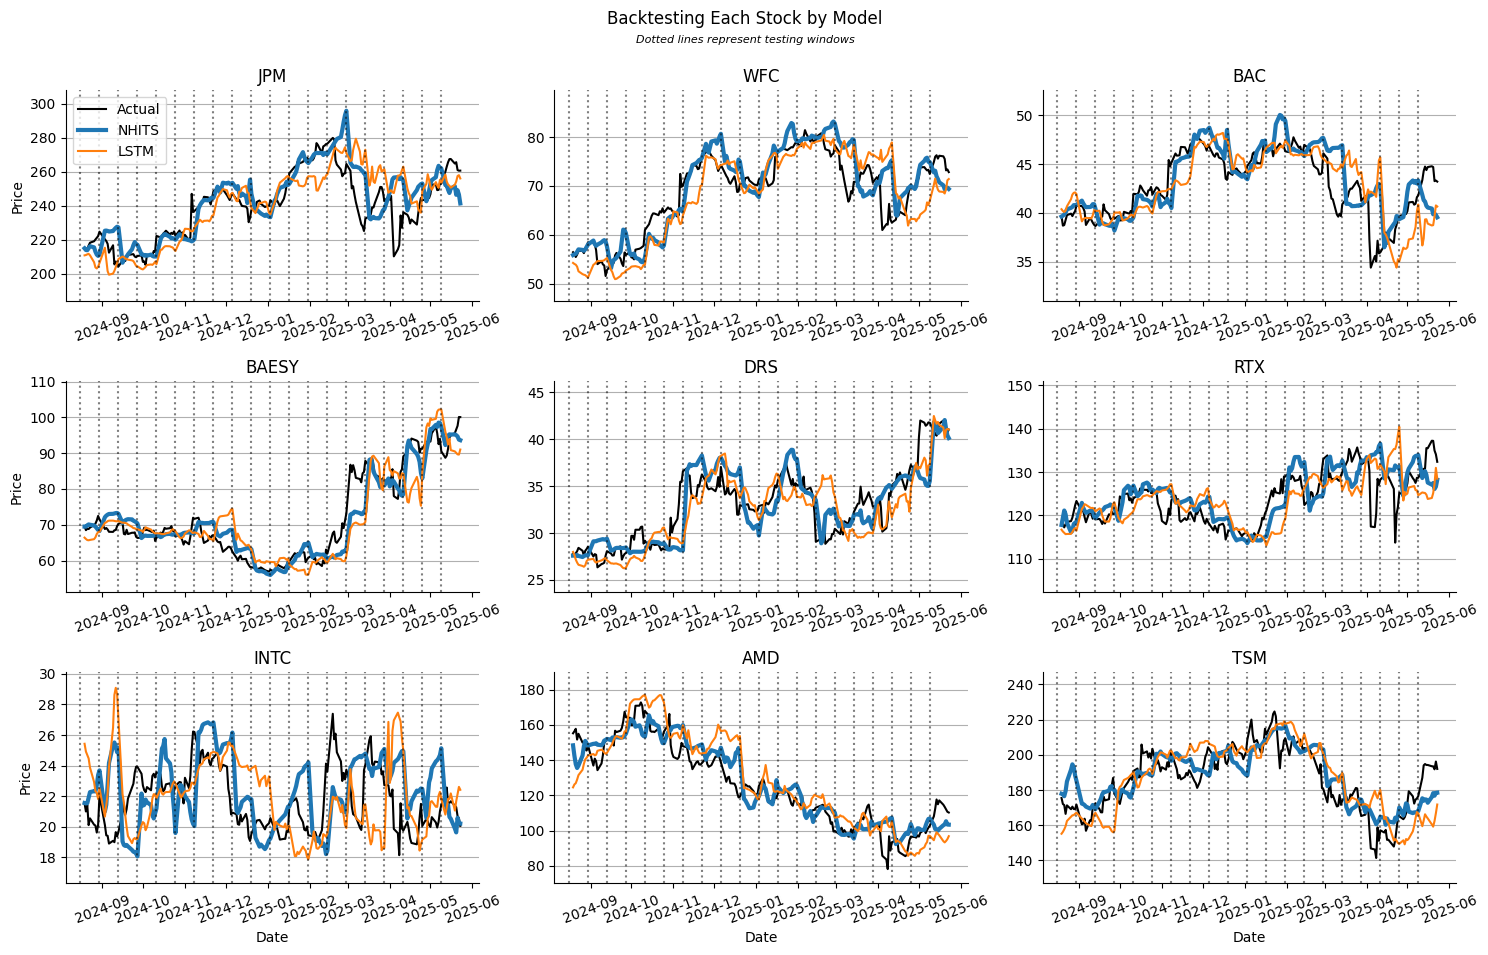

In [109]:
# Backtesting Each Stock by Model
fig, axs = plt.subplots(3, 3, figsize=(15, 10), sharex=False)
fig.suptitle('Backtesting Each Stock by Model')
fig.text(0.5, 0.95, 'Dotted lines represent testing windows',
         ha='center', va='center', fontsize=8,style='italic')

for idx, ticker in enumerate(tickers):
    row = idx // 3
    col = idx % 3
    ax = axs[row, col]

    actual = df_long[df_long['unique_id'] == ticker].set_index('ds')['y']
    nhits_pred = cv_results[cv_results['unique_id'] == ticker].set_index('ds')['NHITS']
    lstm_pred = cv_results[cv_results['unique_id'] == ticker].set_index('ds')['LSTM']
    actual = actual.loc[nhits_pred.index]

    ax.plot(actual, label='Actual', color='black', linewidth=1.5)
    ax.plot(nhits_pred, label='NHITS', linewidth=3)
    ax.plot(lstm_pred, label='LSTM', linewidth=1.5)
    ax.set_ylim(actual.min() * 0.9, actual.max() * 1.1)
    ax.set_title(ticker)
    ax.grid(axis='y')

    for cutoff in cutoffs:
      ax.axvline(x=cutoff, color='black', ls=':',alpha=0.5)
    ax.tick_params(axis='x', labelrotation=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if row == 2:
        ax.set_xlabel('Date')
    if col == 0:
        ax.set_ylabel('Price')

axs[0, 0].legend(loc='upper left', fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

Analyzing their performance through each window of the backtest, both the LSTM and NHITS models struggle to predict significant spikes or valleys. This is expected, because the model cannot see into the future and anticipate significant socioeconomic or market-moving events. Starting from February 2025, both models continue to predict a stable or upward trend at each window despite the actual prices decreasing (see JPM, WFC, BAC, TSM, and AMD). 

Thus, we see a step-like pattern—the models only "sees" a stock has actually decreased at the next forecast window, causing the model to rapidly adjust its forecast to match the last-known true price and creating a jump. This has occured the most for bank stocks, since they are historically quite stable. Having learned this stable pattern, the models frequently predict low movement at each window. Similarly, for stocks that spiked suddenly (such as BAESY and INTC), the models fail to predict a significant jump. Finally, we see that volatile tickers—most notably INTC—are the most challenging to predict, as expected.

### 4.2. Computing and Comparing Overall Portfolio Value

In addition to predicting each stock, I also want to compute the predicted total value of my simulated portfolio. With both models' outputs, I first calculate how many shares of each stock I initially "bought" at the start of 2019. Then, I pivot the forecasts from the `NeuralForecast` long format—which consists of each stock ticker, the closing dates, the NHITS forecasted prices, and the LSTM forecasted prices—back into the original wide-format. Finally, I multiply the number of shares for each stock by the last price. 

In [110]:
def compute_portfolio(forecast_df, initial_prices, weights, initial_investment, shares):
    # Pivot
    pivot_nhits = forecast_df.pivot(index='ds', columns='unique_id', values='NHITS')
    pivot_lstm = forecast_df.pivot(index='ds', columns='unique_id', values='LSTM')
    # Predicted value
    nhits_portfolio = (pivot_nhits * shares).sum(axis=1)
    lstm_portfolio = (pivot_lstm * shares).sum(axis=1)
    return nhits_portfolio, lstm_portfolio

In [111]:
cv_preds = cv_results[['ds', 'unique_id', 'NHITS', 'LSTM']].dropna()
actual_prices = df_long.pivot(index='ds', columns='unique_id', values='y')[tickers] # make sure tickers are in right order
initial_prices = actual_prices.iloc[0]
initial_shares = (weights * initial_investment) / initial_prices
# Predicted value
nhits_portfolio, lstm_portfolio = compute_portfolio(cv_preds, initial_prices,weights,
                                                    initial_investment,initial_shares)

I follow the same procedure as above to calculate the true value of my simulated portfolio.

In [112]:
# Pivot
actual_prices = df_long.pivot(index='ds', columns='unique_id', values='y')
actual_prices = actual_prices[tickers]
# Actual value
actual_portfolio = (actual_prices * initial_shares).sum(axis=1)
actual_portfolio = actual_portfolio.loc[nhits_portfolio.index]

**Overall Portfolio Value Forecast Accuracy**

In [113]:
mae_nhits = mean_absolute_error(actual_portfolio, nhits_portfolio)
mae_lstm = mean_absolute_error(actual_portfolio, lstm_portfolio)
mape_nhits = mean_absolute_percentage_error(actual_portfolio, nhits_portfolio)
mape_lstm = mean_absolute_percentage_error(actual_portfolio, lstm_portfolio)

print(f"NHITS Portfolio MAE: ${mae_nhits:,.2f}")
print(f"NHITS Portfolio MAPE: {mape_nhits:,.4f}")
print(f"LSTM  Portfolio MAE: ${mae_lstm:,.2f}")
print(f"LSTM Portfolio MAPE: {mape_lstm:,.4f}")

print("\nFinal Portfolio Values:")
print(f"Actual: ${actual_portfolio.iloc[-1]:,.2f}")
print(f"NHITS: ${nhits_portfolio.iloc[-1]:,.2f}")
print(f"LSTM : ${lstm_portfolio.iloc[-1]:,.2f}")

NHITS Portfolio MAE: $9,892.75
NHITS Portfolio MAPE: 0.0325
LSTM  Portfolio MAE: $10,516.33
LSTM Portfolio MAPE: 0.0342

Final Portfolio Values:
Actual: $353,883.11
NHITS: $338,439.85
LSTM : $342,872.27


With MAPEs between 0.03-0.04 or predictions off by only 3-4% on average from the true values, I believe that both models are fairly accurate. As expected, the NHITS model performs slightly better in terms of minimizing loss. While the LSTM final value is technically closer to the actual final value, I believe that this is not as important of an indicator compared to the MAPE or MAE. Furthermore, this is just one point-in-time value, so the LSTM model will not always be closer to the actual. While the absolute error is upwards of $\$10,000$, I believe that this amount is fairly negligent considering my initial investment is $\$100,000$ and the final output is nearly four times as much.  

**Plot of Overall Portfolio Value Forecast Accuracy**

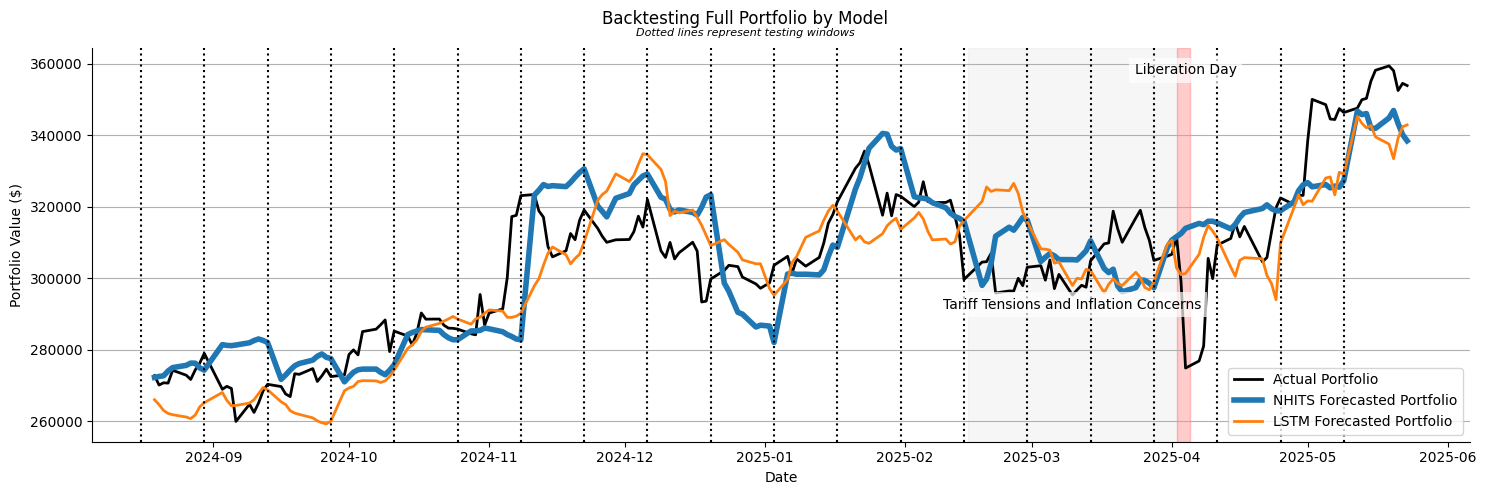

In [115]:
fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle('Backtesting Full Portfolio by Model')
fig.text(0.5, 0.935, 'Dotted lines represent testing windows',
         ha='center', va='center', fontsize=8,style='italic')

ax.plot(actual_portfolio, label='Actual Portfolio', color='black', linewidth=2)
ax.plot(nhits_portfolio, label='NHITS Forecasted Portfolio', linewidth=4)
ax.plot(lstm_portfolio, label='LSTM Forecasted Portfolio', linewidth=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.axvspan(pd.Timestamp('2025-02-15'), pd.Timestamp('2025-04-02'), alpha=0.2,color="lightgrey")
plt.text(pd.Timestamp('2025-03-10'), plt.ylim()[1]*0.8, 'Tariff Tensions and Inflation Concerns',
         ha='center', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.axvspan(pd.Timestamp('2025-04-02'), pd.Timestamp('2025-04-05'), alpha=0.2,color="red")
plt.text(pd.Timestamp('2025-04-04'), plt.ylim()[1]*0.98, 'Liberation Day',ha='center',
         bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.legend()
#plt.title('Backtesting Full Portfolio by Model')
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Date')
plt.tight_layout()

for cutoff in cutoffs:
      plt.axvline(x=cutoff, color='black', ls=':')

plt.grid(axis='y')
plt.show()

Because the full portfolio is just an aggregation of the individual stocks earlier, the issues I have already discussed also apply here—the predictions are in a step-like pattern, where the beginning of each window "jumps" to re-oriente with the actual data. While their forecasts appear to roughly follow the shape of the actual portfolio quite well, I believe the NHITS is more robust to noise, handles multi-seasonality and trends better, and is faster to train. **In summary, for long-horizon forecasts, I prefer NHITS due to its stability, accuracy, and reliability.**

**Note:** I have tested both models on different forecast windows, ranging from 7 days (1 week) to 56 days (8 weeks). As the window size (`forecast_horizon`) increases over 14 days (2 weeks), the LSTM error begins to increase significantly while the NHITS remains fairly consistent. For example, after setting the `forecast_horizon` to 30 days and `n_windows` to 15, the NHITS MAPE still hovers around 3%, but the LSTM MAPE doubles to 6%.

## 5. Potential Improvements

1. By only using neural forecasting models (LSTM and NHITS), this project is fairly limited in scope. In future iterations, I would like to explore the different types of time series models offered in the `NeuralForecast`, `MLForecast`, and `StatsForecast` packages. By incorporating contemporary machine learning models—such as Temporal Fusion Transformers (TFT) and Autoformer—alongside the traditional multivariate statistical models—such as Vector Autoregression and Multiple Regression—I can easily juxtapose each models' benefits or drawbacks. TFTs in particular are extremely popular right now and have demonstrated extremely high accuracy.


  Furthermore, I can leverage external models to forecast a specific variable, such as volatility or volume, and implement them as an exogenous variable within `futr_exog_list`. For example, GARCH (Generalized Autoregressive Conditional Heteroskedasticity) models are ideal when forecasting non-constant volatility over time and computing risk estimations. GARCH assumes that the variance of the error term follows an autoregressive moving average (ARMA) process, allowing it to model how the volatility changes based on past information—most notably squared residuals (past price changes) and previous volatility estimates. As such, I can employ a GARCH model to predict each asset's conditional volatility, before feeding the outputs into my NHITS model as an input feature.


2. Expanding on the benefits of using both NHITS and GARCH, I seek to utilize these models for portfolio optimization and risk management applications. As mentioned earlier, GARCH can be used to forecast volatility ($\sigma_{t}$), while NHITS can be used to generate expected prices or returns ($\mu_t$) for each asset in my portfolio. However, in this context, GARCH is severely limited as it only works with a univariate time series (a single stock). Building upon the GARCH model, I can use DCC-GARCH (Dynamic Conditional Correlation GARCH), which predicts how the volatilities and correlations between *multiple* assets change over time. The DCC-GARCH will:

    >1. Compute each stock's conditional standard deviation ($\sigma_{i,t}$) at time $t$ using a univariate GARCH
    >2. Standardize the residuals (shock in returns) from each GARCH model ($z_{i,t}$)
    >3. Employ the Dynamic Conditional Correlation (DCC) process to construct the time-varying covariance matrix of the standardized residuals ($Q_t$) and the subsequent time-varying correlation matrix ($R_t=\text{diag}(Q_t)^{-1/2} Q_t \text{ diag}(Q_t)^{-1/2}$).
   
   Note that the GARCH residuals do not use NHITS forecasts as expected returns but GARCH’s own fitted mean.

   In order to generate the conditional covariance matrix ($\Sigma_t$), I "sandwich" the time-varying correlation matrix ($R_t$) between two diagnonal matrices (triple matrix product) consisting of the univariate GARCH ouputs ($D_t$)—which are the conditional standard deviations/volatilities for each stock ($\sigma_{i,t}$) I have already calculated in Step A. This final matrix ($\Sigma_t = D_t R_t D_t$) accounts for time-varying volatilities and correlations. Thankfully, there are Python packages that simplify this process.

   > **Note**: The covariance matrix of asset returns can also be calculated using historical prices, which only requires calculating the log returns for each stock and computing the covariance matrix. Because this method relies on stationary data, it is only well-suited for extremely stable markets and is not as accurate as using GARCH. However, this is a lot easier and simpler to implement, requiring less computational resources and time.

   Finally, dividing the expected portfolio returns from my NHITS model ($\boldsymbol{\mu}$) by the square root of the conditional covariance matrix ($\boldsymbol{\Sigma}$) from DCC-GARCH, I can calculate the list of asset weights ($w$) that maximize the Sharpe ratio ($\frac{w^T \mu_t - R_{f,t}}{\sqrt{w^T \Sigma_t w}}$). Assuming it exists, I can also subtract the portfolio returns by the risk-free rate ($R_f$). This process computes the optimal portfolio weights for each stock depending on the model forecasts. Thus, it is extremely important the the model parameters are up-to-date.

4. Because historical stock data is frequently revised and updated retroactively—accounting for splits, dividends, and corrections—the training data quality often changes day-to-day, affecting hyperparameter tuned and feature engineered variables. As such, portfolio managers tend to re-tune weekly or monthly, ensuring parameters are relatively up-to-date while preserving computational costs. For a real-life scenario, I believe incorporating a model drift detection mechanism is necessary, specifically a rolling Sharpe ratio.

   In short, I use my NHITS forecasts to compute the optimal portfolio weights, maximizing the Sharpe ratio for a specific day. Then, I implement those weights and track the actual returns. Finally, I compute the Sharpe ratio over a window (such as 30 days) to monitor how well my strategy is performing relative to its risk on a rolling basis. If the rolling Sharpe ratio starts to fall significantly, then I know I need to re-train my model and re-optimize weights.

6. The hyperparameter tuning grid right now does not include any exogenous variables. In this project's current state, I randomly select which variables to use for each model, relying on educated guesses and repeated testing. In future edits, I seek to implement different combinations of the exogenous variables in the tuning process in order to find the optimal set. Furthermore, I want to incorporate more regularization techniques. I believe both models are still overfitting the data, which can significantly decrease accuracy as time progresses.